In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import scipy

import datetime
import os

import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [17]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
# Define portfolio asset class breakdown
assets = {
    #Growth Assets
    'BTC-USD': 'BTC',
    'QQQM': 'Nasdaq-100 ETF',

    #Hedging Assets
    'GLD': 'Gold Commodity',
    'BND': 'Vanguard Total Bond Market Index Fund',

    #Stable Income
    'SCHV': 'High Yield Dividend-Paying ETF (10%'
}

tickers = ['BTC-USD', 'QQQM', 'GLD', 'BND', 'SCHV']
start_date = '2020-01-01'
end_date = datetime.datetime.today().strftime('%Y-%m-%d')

['BTC-USD', 'QQQM', 'GLD', 'BND', 'SCHV']


In [ ]:
# Download asset date from yfinance

asset_data = pd.DataFrame()

for symbol in tickers:
    asset_data = yf.download(symbol, start=start_date, end=end_date)
    asset_data['ticker'] = symbol  # Add a column for the ticker symbol

    asset_data.rename(columns={
        'Date': 'date',
        'Adj Close': 'adj_close',
        'Close': 'close',
        'High': 'high',
        'Low': 'low',
        'Open': 'open',
        'Volume': 'volume'
    }, inplace=True)

    asset_data.to_csv(f'{symbol}.csv')

#print(asset_data.head)

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

<bound method NDFrame.head of Price           close       high        low       open   volume ticker
Ticker           SCHV       SCHV       SCHV       SCHV     SCHV       
Date                                                                  
2020-01-02  15.661394  15.661394  15.575883  15.656211  1887300   SCHV
2020-01-03  15.531830  15.575881  15.477414  15.503326  1890900   SCHV
2020-01-06  15.542196  15.549969  15.443729  15.454093  1189200   SCHV
2020-01-07  15.500739  15.524059  15.469644  15.518877  1076400   SCHV
2020-01-08  15.526648  15.599203  15.482598  15.500736  1962600   SCHV
...               ...        ...        ...        ...      ...    ...
2025-03-27  26.650000  26.770000  26.540001  26.670000  1120800   SCHV
2025-03-28  26.320000  26.660000  26.250000  26.590000  1483900   SCHV
2025-03-31  26.580000  26.709999  26.160000  26.160000  2745600   SCHV
2025-04-01  26.570000  26.650000  26.299999  26.520000  1533500   SCHV
2025-04-02  26.740000  26.770000  26.360001  26

In [ ]:
# Concatenate all data into new df

new_directory = 'dse4211/dataset'
os.chdir(new_directory)

files = os.listdir(new_directory)
temp = []

for file in files:
    if file.endswith('.csv'):
        df_file_path = os.path.join(new_directory, file)
        df = pd.read_csv(df_file_path)
        temp.append(df)

temp_df = pd.concat(temp, ignore_index=True)
temp_df.to_csv('raw_data.csv', index=False)

In [ ]:
# Data description for pre-transformed df

combined_data = pd.read_csv('dse4211/dataset/raw_data.csv')
combined_data.describe().style

,close,high,low,open,volume
count,7002.000000,7002.000000,7002.000000,7002.000000,7002.000000
mean,10776.991247,10999.027286,10522.644527,10766.865777,9239016787.865038
std,21429.431326,21873.176465,20926.033559,21413.619623,18273348421.263561
min,9.950321,10.302728,9.792257,10.297546,13100.000000
25%,69.317581,69.460717,69.182744,69.334272,1566975.000000
50%,157.969994,158.985753,157.039993,158.086683,5780700.000000
75%,9604.830810,9701.060791,9424.333985,9589.755371,13839191791.250000
max,106146.265600,109114.882800,105291.734400,106147.296900,350968000000.000000


In [ ]:
# Skewness and kurtosis for pre-transformed data

original_numeric_columns = combined_data.select_dtypes(include=['number']).columns
original_skewness = combined_data[original_numeric_columns].apply(scipy.stats.skew, axis=0)
original_kurtosis = combined_data[original_numeric_columns].apply(scipy.stats.kurtosis, axis=0)

print(original_skewness)
print(original_kurtosis)

close     2.190501
high      2.186986
low       2.196668
open      2.191818
volume    3.073929
dtype: float64
close      4.285111
high       4.259793
low        4.330565
open       4.294175
volume    22.960403
dtype: float64


In [ ]:
# Perform log-transformation on initial df features and append columns to initial df

combined_data["close_log"] = np.log(combined_data["close"])
combined_data["high_log"] = np.log(combined_data["high"])
combined_data["low_log"] = np.log(combined_data["low"])
combined_data["open_log"] = np.log(combined_data["open"])
combined_data["volume_log"] = np.log(combined_data["volume"])
combined_data["ticker"] = combined_data["ticker"]


In [ ]:
# Encode df to transform date and ticker columns into integers
# Correlation matrix for 

encoded_df = combined_data
label_encoder = LabelEncoder()

encoded_df['date_encoded'] = label_encoder.fit_transform(encoded_df['date'])
encoded_df['ticker_encoded'] = label_encoder.fit_transform(encoded_df['ticker'])

correlation_matrix = encoded_df.select_dtypes(include=['float64', 'int64']).corr()
correlation_matrix.style.background_gradient(cmap='coolwarm')

,close,high,low,open,volume,close_log,high_log,low_log,open_log,volume_log,date_encoded,ticker_encoded
close,1.000000,0.999750,0.999691,0.999415,0.769575,0.845675,0.845727,0.845551,0.845619,0.797731,-0.001681,-0.318169
high,0.999750,1.000000,0.999519,0.999729,0.774151,0.845706,0.845839,0.845592,0.845739,0.798264,-0.001783,-0.318174
low,0.999691,0.999519,1.000000,0.999604,0.763228,0.845378,0.845440,0.845352,0.845398,0.796838,-0.001549,-0.318088
open,0.999415,0.999729,0.999604,1.000000,0.769789,0.845445,0.845586,0.845395,0.845569,0.797577,-0.001683,-0.318102
volume,0.769575,0.774151,0.763228,0.769789,1.000000,0.801694,0.802701,0.800380,0.801755,0.831313,-0.004424,-0.322549
close_log,0.845675,0.845706,0.845378,0.845445,0.801694,1.000000,0.999989,0.999988,0.999977,0.944204,0.000622,-0.471108
high_log,0.845727,0.845839,0.845440,0.845586,0.802701,0.999989,1.000000,0.999977,0.999989,0.944412,0.000533,-0.470486
low_log,0.845551,0.845592,0.845352,0.845395,0.800380,0.999988,0.999977,1.000000,0.999983,0.943954,0.000714,-0.471840
open_log,0.845619,0.845739,0.845398,0.845569,0.801755,0.999977,0.999989,0.999983,1.000000,0.944191,0.000563,-0.471131
volume_log,0.797731,0.798264,0.796838,0.797577,0.831313,0.944204,0.944412,0.943954,0.944191,1.000000,0.000581,-0.507982


In [18]:
encoded_df.to_csv('asset_portfolio_latest.csv', index=False)

In [ ]:
# Create separate dataset with log-transformed features

asset_portfolio = pd.DataFrame()

asset_portfolio["date"] = combined_data["date"]
asset_portfolio["close_log"] = np.log(combined_data["close"])
asset_portfolio["high_log"] = np.log(combined_data["high"])
asset_portfolio["low_log"] = np.log(combined_data["low"])
asset_portfolio["open_log"] = np.log(combined_data["open"])
asset_portfolio["volume_log"] = np.log(combined_data["volume"])
asset_portfolio["ticker"] = combined_data["ticker"]

asset_portfolio.describe().style

,close_log,high_log,low_log,open_log,volume_log
count,7002.000000,7002.000000,7002.000000,7002.000000,7002.000000
mean,5.992461,6.001354,5.982202,5.992099,17.348181
std,2.809996,2.816529,2.802139,2.809538,4.276798
min,2.297605,2.332409,2.281592,2.331906,9.480368
25%,4.238699,4.240761,4.236751,4.238939,14.264658
50%,5.062405,5.068815,5.056501,5.063144,15.570035
75%,9.170021,9.179991,9.151049,9.168451,23.350770
max,11.572573,11.600157,11.564490,11.572583,26.583961


In [ ]:
# Skewness and kurtosis for log-tranformed features

transformed_numeric_columns = asset_portfolio.select_dtypes(include=['number']).columns
transformed_skewness = asset_portfolio[transformed_numeric_columns].apply(scipy.stats.skew, axis=0)
transformed_kurtosis = asset_portfolio[transformed_numeric_columns].apply(scipy.stats.kurtosis, axis=0)

print(transformed_skewness)
#print(transformed_kurtosis)

close_log     0.816603
high_log      0.817836
low_log       0.815180
open_log      0.816577
volume_log    0.834967
dtype: float64
close_log    -0.886818
high_log     -0.886920
low_log      -0.886500
open_log     -0.886573
volume_log   -0.980303
dtype: float64


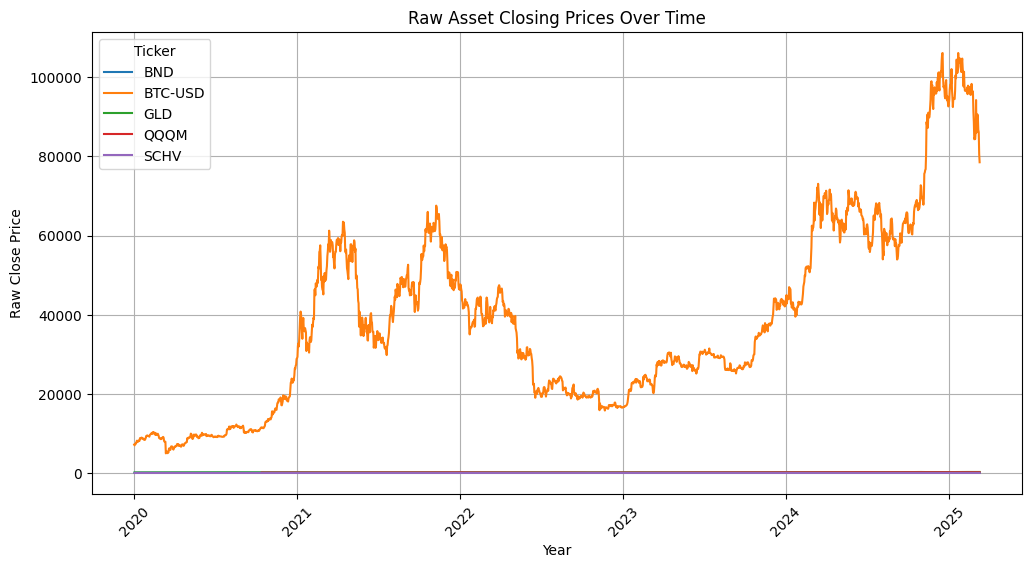

In [ ]:
## Plot original close prices

# Convert date column to datetime
combined_data["date"] = pd.to_datetime(combined_data["date"], format="%d/%m/%y") 

# Set the date column as the index
combined_data.set_index('date', inplace=True)

# Create a line plot for each ticker
plt.figure(figsize=(12, 6))

for ticker, group in combined_data.groupby('ticker'):
    plt.plot(group.index, group['close'], label=ticker)


# Adding titles and labels
plt.title('Raw Asset Closing Prices Over Time')
plt.xlabel('Year')
plt.ylabel('Raw Close Price')
plt.legend(title='Ticker')
plt.grid()
plt.xticks(rotation=45)  

# Show the plot
plt.show()

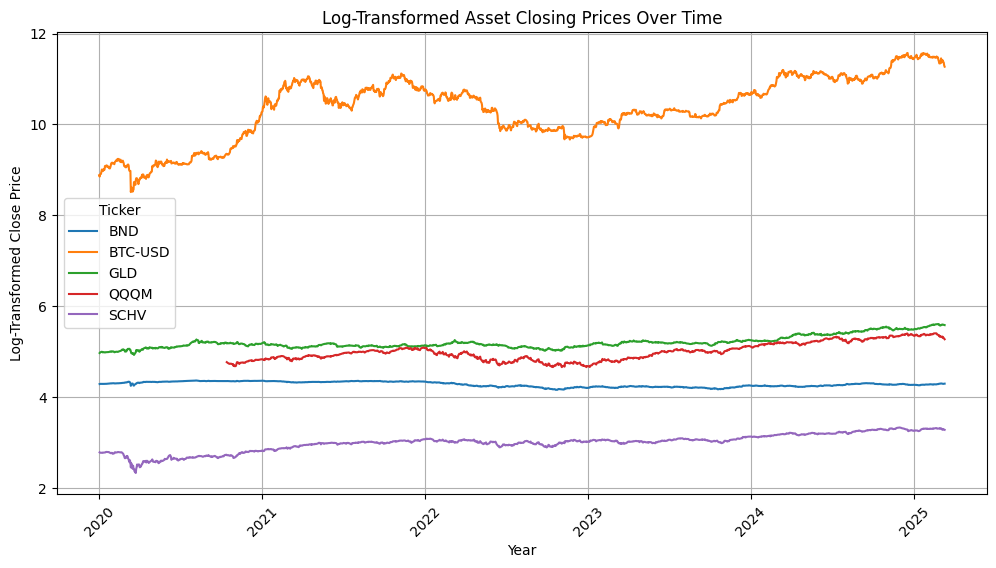

In [ ]:
## Plot log-transformed close prices

# Convert date column to datetime
asset_portfolio["date"] = pd.to_datetime(asset_portfolio["date"], format="%d/%m/%y") 

# Set the date column as the index
asset_portfolio.set_index('date', inplace=True)

# Create a line plot for each ticker
plt.figure(figsize=(12, 6))

for ticker, group in asset_portfolio.groupby('ticker'):
    plt.plot(group.index, group['close_log'], label=ticker)


# Adding titles and labels
plt.title('Log-Transformed Asset Closing Prices Over Time')
plt.xlabel('Year')
plt.ylabel('Log-Transformed Close Price')
plt.legend(title='Ticker')
plt.grid()
plt.xticks(rotation=45)  

# Show the plot
plt.show()

In [ ]:
portfolio_with_features = pd.read_csv('dse4211/dataset/asset_portfolio_with_featuresv2.csv')
portfolio_with_features["date"] = pd.to_datetime(portfolio_with_features["date"], format='mixed', dayfirst=True)

In [ ]:
portfolio_with_features.set_index('date', inplace=True)
portfolio_with_features = portfolio_with_features.sort_index()
#print(portfolio_with_features.head())

                  close         high          low         open        volume  \
date                                                                           
2020-01-17   146.580002   146.990005   146.309998   146.509995  1.112110e+07   
2020-01-17    73.061028    73.069691    72.974412    72.991733  3.090600e+06   
2020-01-17  8929.038086  8958.122070  8677.316406  8725.209961  3.637214e+10   
2020-01-17    16.317472    16.336189    16.296085    16.320147  9.954000e+05   
2020-01-18  8942.808594  9012.198242  8827.332031  8927.211914  3.233777e+10   

            close_log  high_log   low_log  open_log  volume_log  ...  \
date                                                             ...   
2020-01-17   4.987571  4.990365  4.985728  4.987094   16.224355  ...   
2020-01-17   4.291295  4.291414  4.290109  4.290346   14.943876  ...   
2020-01-17   9.097064  9.100316  9.068468  9.073972   24.317069  ...   
2020-01-17   2.792236  2.793383  2.790925  2.792400   13.810900  ...   
2020-01

In [13]:
#Augmented Dickey-Fuller (ADF) Test
adf_test = adfuller(portfolio_with_features['close_log'])
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")

if adf_test[1] < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary (differencing may be needed).")

ADF Statistic: -7.225723025984675
p-value: 2.055597548068169e-10
The time series is stationary.


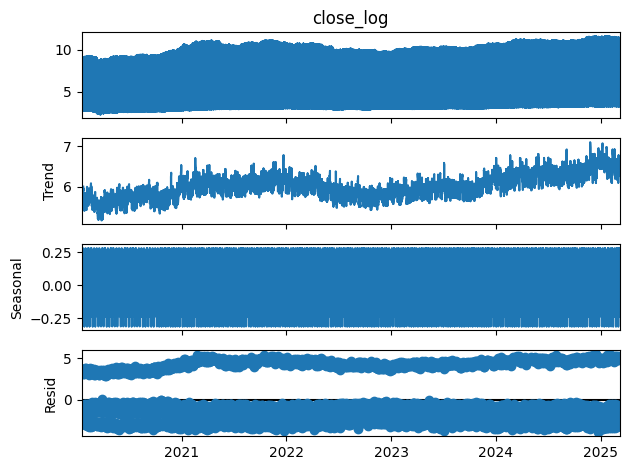

In [16]:
#Decompose Time Series
result = seasonal_decompose(portfolio_with_features['close_log'], model='additive', period=30)  # Adjust period as needed
result.plot()
plt.show()

<Figure size 1200x500 with 0 Axes>

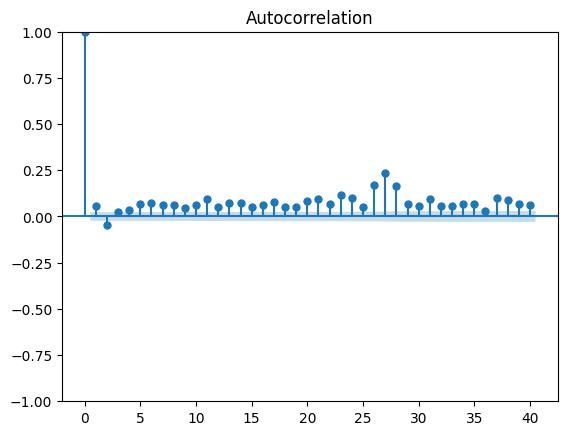

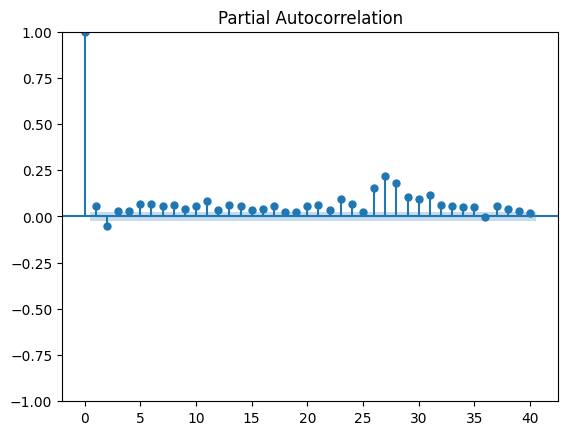

In [ ]:
# Check for lags using ACF & PACF
plt.figure(figsize=(12,5))
plot_acf(portfolio_with_features['close_log'].dropna(), lags=40)  # Autocorrelation
plot_pacf(portfolio_with_features['close_log'].dropna(), lags=40)  # Partial Autocorrelation
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


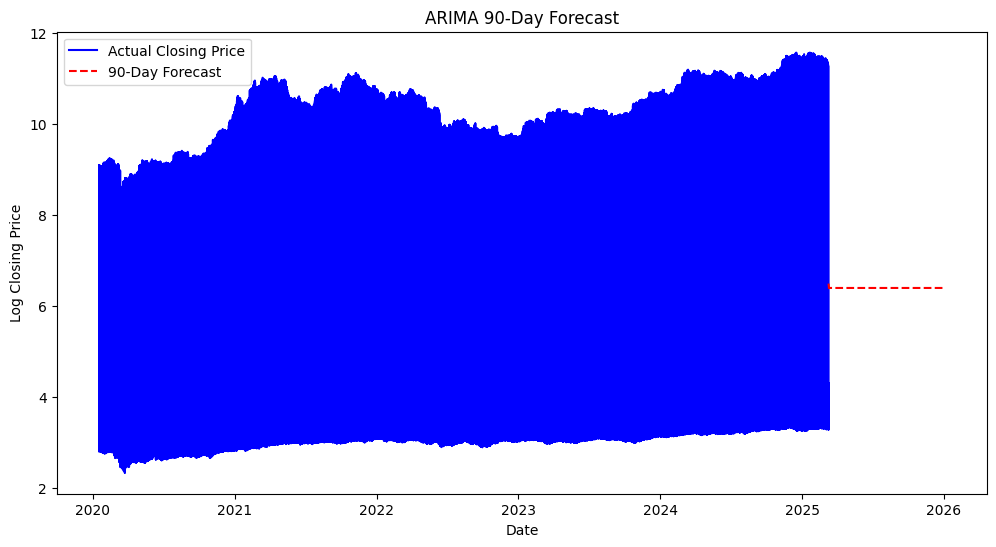

In [30]:
# Fit ARIMA Model (adjust p, d, q based on ACF/PACF)
model = ARIMA(portfolio_with_features['close_log'], order=(1,1,1))  # Example order (p,d,q)
model_fit = model.fit()

# Forecast for the next 90 days
forecast = model_fit.forecast(steps=300)

# Generate future date range
future_dates = pd.date_range(portfolio_with_features.index[-1], periods=300, freq='D')

# Plot Forecast
plt.figure(figsize=(12,6))
plt.plot(portfolio_with_features.index, portfolio_with_features['close_log'], label='Actual Closing Price', color='blue')
plt.plot(future_dates, forecast, label='90-Day Forecast', linestyle='dashed', color='red')

plt.xlabel('Date')
plt.ylabel('Log Closing Price')
plt.title('ARIMA 90-Day Forecast')
plt.legend()
plt.show()

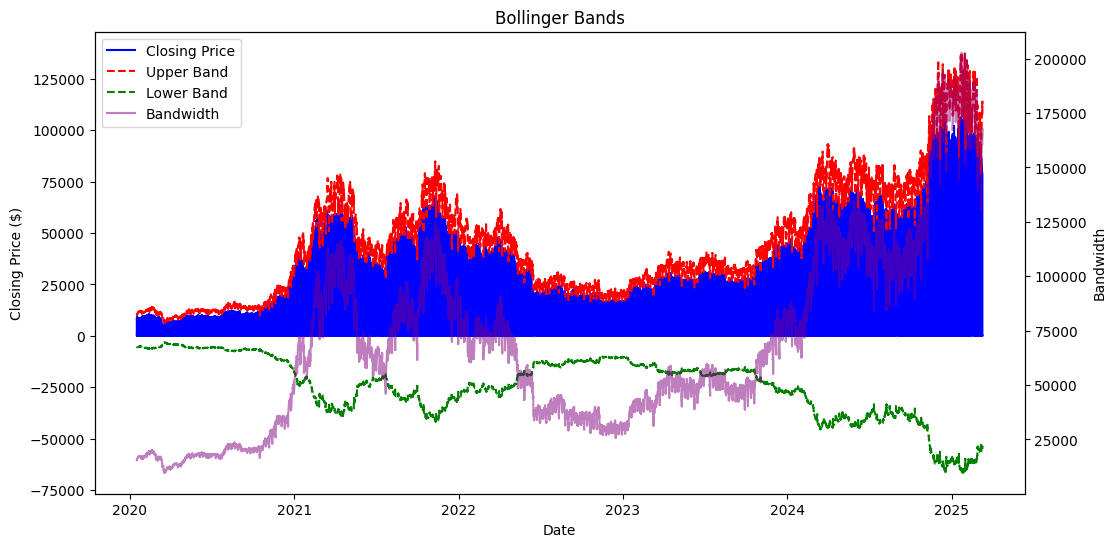

In [ ]:
# Plot Bollinger bands for pre-transformed close prices
plt.figure(figsize=(12, 6))

# Main axis
ax = plt.gca()
line1, = ax.plot(portfolio_with_features['date'], portfolio_with_features['close'], label='Closing Price', color='blue')
line2, = ax.plot(portfolio_with_features['date'], portfolio_with_features['Bollinger_Upper'], label='Upper Band', linestyle='dashed', color='red')
line3, = ax.plot(portfolio_with_features['date'], portfolio_with_features['Bollinger_Lower'], label='Lower Band', linestyle='dashed', color='green')

ax.set_xlabel('Date')
ax.set_ylabel('Closing Price ($)')

# Secondary y-axis for Bandwidth
ax2 = ax.twinx()
line4, = ax2.plot(portfolio_with_features['date'], portfolio_with_features['Bollinger_Bandwidth'], label='Bandwidth', color='purple', alpha=0.5)
ax2.set_ylabel('Bandwidth')

# Combine legends from both axes
lines = [line1, line2, line3, line4]
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc='upper left')

plt.title('Bollinger Bands')
plt.show()